### System Analysis
This notebook contains the analysis functions to calculate steady state error for each controller architecture.
Plotting functions are included to support analysis.

Import Controller ODE Solutions

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import string
from matplotlib.ticker import ScalarFormatter, MultipleLocator
from controllers import *
import seaborn as sns
sns.set

# =========================================
# Setup Matplotlib Params
# =========================================
plt.rcParams['font.size'] = 14  
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

# =========================================
# Miscellaneous Utilities
# =========================================
def calculate_SSE(solution):
    '''
    the solution is a pandas dataframe with the columns 
    time[s], X, Y, A, P_Y+, O

    X is the reference
    O is the output
    '''
    error = solution["O"] - solution["reference"] 
    SSE = error.iloc[-1]
    return SSE

def line_properties(controller_type: str, markers: bool = False):
    if controller_type == "direct" or controller_type.startswith("d"):
        line_properties = {"color" : "#e66600", "linewidth" : 2}
        marker = "x"
    elif controller_type == "indirect" or controller_type.startswith("i"):
        line_properties = {"color" : "#008080", "linewidth" : 2}
        marker = "o"    
    else:
        print("Controller type must be 'direct' or 'indirect'")
        raise TypeError
    
    if markers:
        line_properties.update({"marker" : marker, "markersize" : 10, "fillstyle" : "none"})
    
    return line_properties

def add_subplot_labels(ax_array, fontsize=16, fontweight='normal', x=-0.2, y = 1.05):
    """
    Adds figure labels (e.g., 'A', 'B', 'C', ...) outside the plot area to the upper-left corner
    of each subplot in the given numpy array of axes.

    Parameters:
    - ax_array: A 2D numpy array of axes objects from `plt.subplots()`.
    - fontsize: The font size of the label (default is 14).
    - fontweight: The font weight of the label (default is 'bold').
    """
    ax_flat = ax_array.flatten()

    letter_list = list(string.ascii_uppercase) 
    letter_idx = 0  

    for ax in ax_flat:
        if letter_idx < len(letter_list):
            label = letter_list[letter_idx]
            ax.text(x,y, label, transform=ax.transAxes, fontsize=fontsize, fontweight=fontweight, 
                    va='bottom', ha='left', color='black', backgroundcolor='None', zorder=10)
            letter_idx += 1  

    plt.subplots_adjust(wspace=0.25, hspace=0.3)  

# =========================================
# Define Plotting Functions
# =========================================
def plot_solution(ax, solution):
    time_hrs = solution["time[s]"] / 3600
    for column in solution:
        if column != "time[s]":
            ax.plot(time_hrs, solution[column], label=to_latex_label(column))
    ax.set_xlabel("Time [hr]")
    ax.set_ylabel("Species Concentration [nM]")
    return ax.figure, ax

def plot_input_output(ax, solution, controller_type, add_reference = False):
    time_hrs = solution["time[s]"] / 3600
    label = "Indirect" if "indirect" in controller_type else "Direct"
    ax.plot(time_hrs, solution["O"], label=label,  **line_properties(controller_type))
    if add_reference == True:
        ax.plot(time_hrs, solution["reference"], label="Reference", linestyle = "--", linewidth = 3, color = "gray")
    ax.set_xlabel("Time [hr]")
    ax.set_ylabel("Species Concentration [nM]")
    return ax.figure, ax

def get_fig2a_data(controller_func, PARAMS):
    # define initial conditions
    P_X = [0, 6, 12, 18, 24, 30] # [nM]
    P_Y = 20 # [nM]

    # loop through initial conditions for each controller solution
    steady_state_values = []
    for ic in P_X:
        PARAMS["PX"] = ic
        PARAMS["PY"] = P_Y
        solution = controller_func(PARAMS)
        steady_state_values.append(solution.iloc[-1])
    return P_X, steady_state_values


def get_fig2b_data(controller_func, PARAMS):
    P_X = [0, 6, 12, 18, 24, 30] # [nM]
    P_Y = 20 # [nM]

    steady_state_errors = []
    for ic in P_X:
        PARAMS["PX"] = ic
        PARAMS["PY"] = P_Y
        solution = controller_func(PARAMS)
        steady_state_errors.append(calculate_SSE(solution))
    return P_X, steady_state_errors

def plot_fig2a(ax, fig2a_data, controller_type, add_reference: bool = False):
    P_X, steady_state_values = fig2a_data

    output = [ss_value["O"] for ss_value in steady_state_values]
    reference = [ss_value["reference"] for ss_value in steady_state_values]

    label = controller_type.capitalize()
    ax.plot(P_X, output, label=label,  **line_properties(controller_type, markers=True))

    if add_reference == True:
        ax.plot(P_X, reference, label="Reference", linestyle = "--", linewidth = 3, color = "gray")

    ax.set_xlabel(to_latex_label("P_X")  + " [nM]")
    ax.set_ylabel("Species Concentration [nM]")
    return ax.figure, ax

def plot_fig2b(ax, fig2b_data, controller_type):
    P_X, steady_state_errors = fig2b_data

    label = controller_type.capitalize()
    ax.plot(P_X, steady_state_errors, label=label,  **line_properties(controller_type, markers=True))

    ax.set_xlabel(to_latex_label("P_X")  + " [nM]")
    ax.set_ylabel("Steady State Error [nM]")
    return ax.figure, ax

def plot_temp_dependence(ax, temperatures, PARAMS, controller_func, label):

    # initial conditions are defined in this function

    steady_state_errors = []
    for temp in temperatures:
        PARAMS["temperature"] = temp
        SSE = calculate_SSE(controller_func(PARAMS))
        steady_state_errors.append(SSE)
    controller_type = controller_func.__name__
    ax.plot(temperatures, steady_state_errors, label=label, **line_properties(controller_type, markers=True))

    ax.set_xlabel("Temperature [C]")
    ax.set_ylabel("Steady State Error [nM]")

    return ax.figure, ax

C:\Users\isaac\AppData\Local\Temp\ipykernel_31860\2431067531.py:46: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\isaac\AppData\Local\Temp\ipykernel_31860\2431067531.py:78: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()
C:\Users\isaac\AppData\Local\Temp\ipykernel_31860\2431067531.py:79: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\isaac\AppData\Local\Temp\ipykernel_31860\2431067531.py:80: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig("plots/input_output_ode_solutions.png", dpi=600)
C:\Users\isaac\AppData\Local\Temp\ipykernel_31860\2431067531.py:134: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\isaac\AppData\Local\Temp\ipykernel_31860\2431067531.py:168: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
 

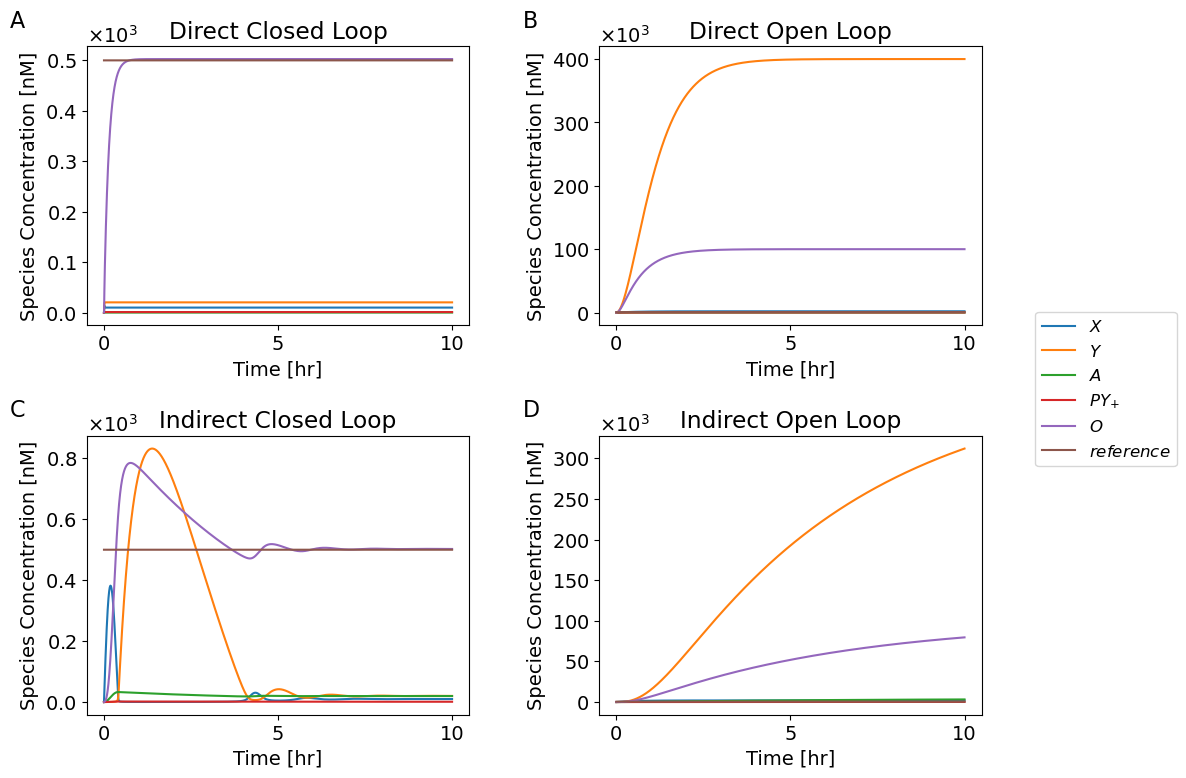

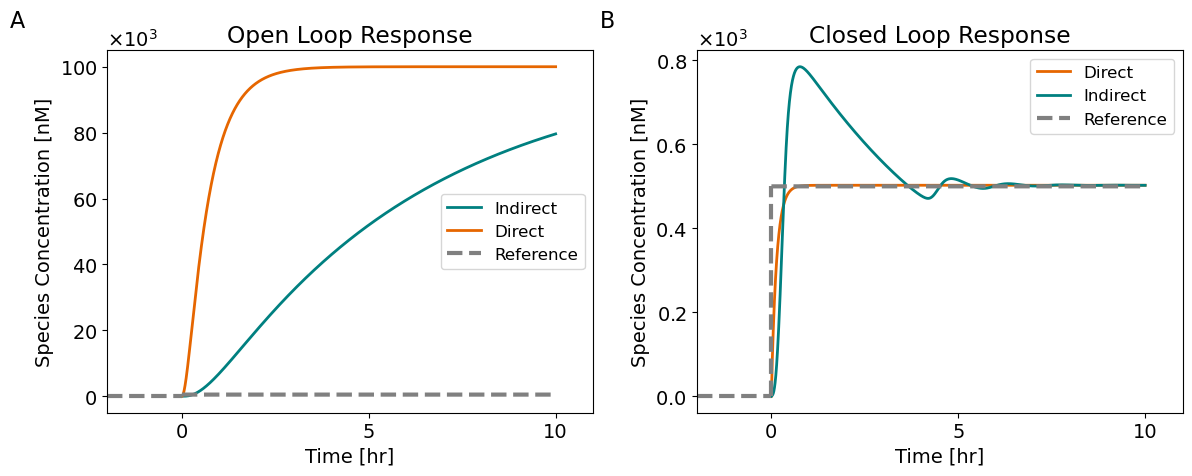

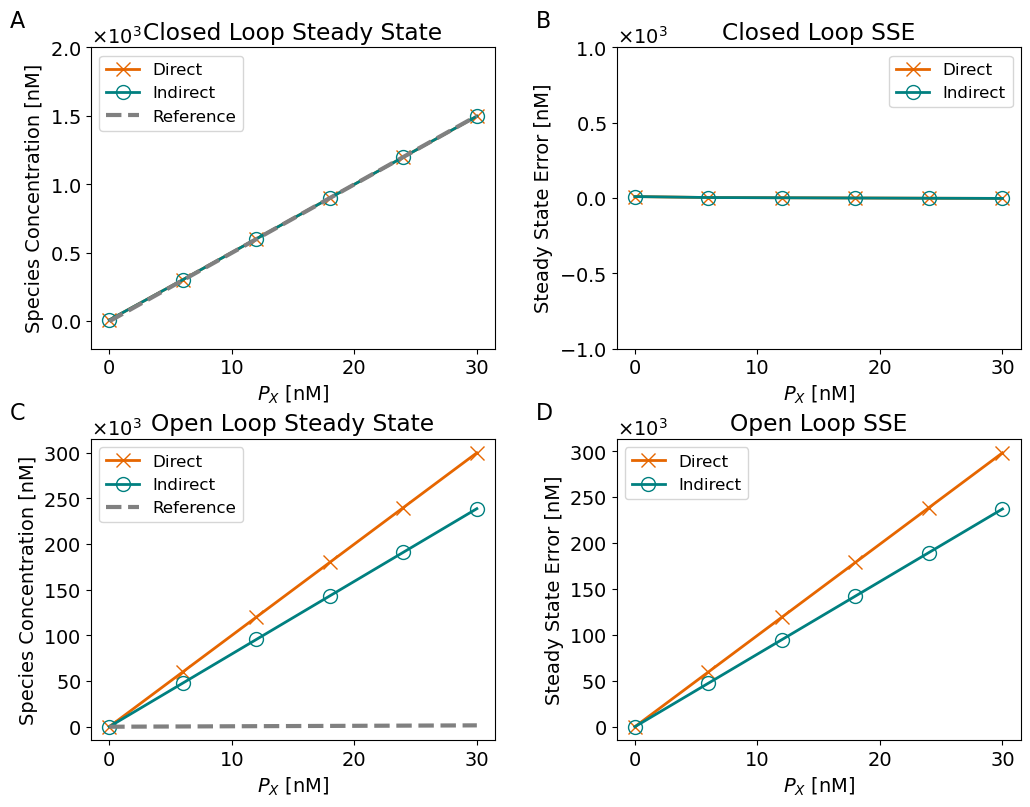

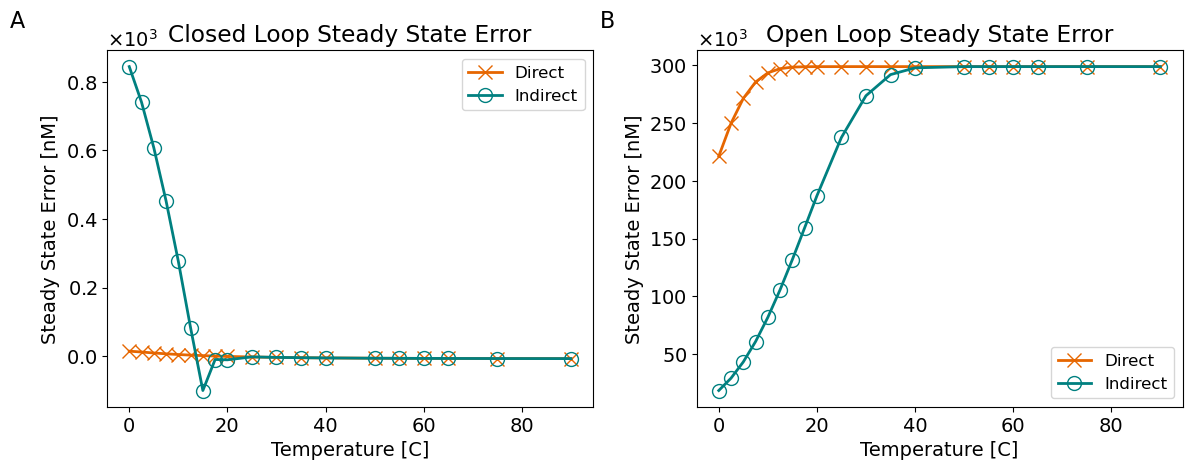

In [ ]:
# =========================================
# Figure 1 e-f
# =========================================

# ==========
# NOTE: all plots in this section with same initial conditions
# ==========

# concentrations in nM
PARAMS = {
    "temperature": 25,
    "PX": 10,
    "PY": 20,
    "X_init": 0,
    "Y_init": 0,
    "A_init": 0,
    "PY_plus_init": 0,
    "O_init": 0,
    "t_end": 36000,
    "t_steps": int(1E6),
    }

fig, axs = plt.subplots(2,2, figsize=(12,8))
fig, axs[0,0] = plot_solution(axs[0,0], dcl_solution(PARAMS))
fig, axs[0,1] = plot_solution(axs[0,1], dol_solution(PARAMS))
fig, axs[1,0] = plot_solution(axs[1,0], icl_solution(PARAMS))
fig, axs[1,1] = plot_solution(axs[1,1], iol_solution(PARAMS))

subplot_titles = ["Direct Closed Loop", "Direct Open Loop",
                  "Indirect Closed Loop", "Indirect Open Loop"]

for ax, title in zip(axs.flatten(), subplot_titles) :
    ax.set_title(title)

handles, labels = axs[0,0].get_legend_handles_labels()
add_subplot_labels(axs)
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.87, 0.5), fontsize=12)
fig.tight_layout(rect=[0, 0, 0.85, 1])
for ax_row in axs:
    for ax in ax_row:
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((3, 3))  # Force scientific notation at 10^3
        ax.yaxis.set_major_formatter(formatter)
        ax.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
        ax.xaxis.set_major_locator(MultipleLocator(5))
fig.show()
fig.savefig("plots/full_ode_solutions.png", dpi=600)


# ----------------------------------------

fig, axs = plt.subplots(1,2, figsize=(12,5))
fig, axs[0] = plot_input_output(axs[0], iol_solution(PARAMS), "indirect")
fig, axs[0] = plot_input_output(axs[0], dol_solution(PARAMS), "direct", add_reference = True)
fig, axs[1] = plot_input_output(axs[1], dcl_solution(PARAMS), "direct")
fig, axs[1] = plot_input_output(axs[1], icl_solution(PARAMS), "indirect", add_reference = True)

for ax in axs.flatten():
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((3, 3))  # Force scientific notation at 10^3
    ax.yaxis.set_major_formatter(formatter)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.set_xlim(-2,11)
    ax.plot([-2, 0], [0, 0], linestyle = "--", linewidth = 3, color = "gray")
    ax.plot([0, 0], [0, 500], linestyle = "--", linewidth = 3, color = "gray")

axs[1].yaxis.set_major_locator(MultipleLocator(200))

    
subplot_titles = ["Open Loop Response", "Closed Loop Response"]

for ax, title in zip(axs.flatten(), subplot_titles) :
    ax.legend(fontsize=12)
    ax.set_title(title)

add_subplot_labels(axs)
fig.tight_layout()
fig.show()
fig.savefig("plots/input_output_ode_solutions.png", dpi=600)


# =========================================
# Figure 2a-b
# =========================================

# ==========
# NOTE: all plots in this section use initial conditions defined in the get_data functions
# ==========
fig2_params = PARAMS
fig2a_data_dcl = get_fig2a_data(dcl_solution, fig2_params)
fig2a_data_icl = get_fig2a_data(icl_solution, fig2_params)
fig2a_data_dol = get_fig2a_data(dol_solution, fig2_params)
fig2a_data_iol = get_fig2a_data(iol_solution, fig2_params)

fig2b_data_dcl = get_fig2b_data(dcl_solution, fig2_params)
fig2b_data_icl = get_fig2b_data(icl_solution, fig2_params)
fig2b_data_dol = get_fig2b_data(dol_solution, fig2_params)
fig2b_data_iol = get_fig2b_data(iol_solution, fig2_params)


fig, axs = plt.subplots(2,2, figsize=(12,9), sharey=False)
fig, axs[0,0] =  plot_fig2a(axs[0,0], fig2a_data_dcl, "direct")
fig, axs[0,0] =  plot_fig2a(axs[0,0], fig2a_data_icl, "indirect", add_reference=True)
fig, axs[0,1] =  plot_fig2b(axs[0,1], fig2b_data_dcl, "direct")
fig, axs[0,1] =  plot_fig2b(axs[0,1], fig2b_data_icl, "indirect")

axs[0,0].set_ylim(-200, 2000)
axs[0,1].set_ylim(-1000, 1000)

fig, axs[1,0] =  plot_fig2a(axs[1,0], fig2a_data_dol, "direct")
fig, axs[1,0] =  plot_fig2a(axs[1,0], fig2a_data_iol, "indirect", add_reference=True)
fig, axs[1,1] =  plot_fig2b(axs[1,1], fig2b_data_dol, "direct")
fig, axs[1,1] =  plot_fig2b(axs[1,1], fig2b_data_iol, "indirect")

for ax_row in axs:
    for ax in ax_row:
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((3, 3))  # Force scientific notation at 10^3
        ax.yaxis.set_major_formatter(formatter)
        ax.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
        ax.xaxis.set_major_locator(MultipleLocator(10))

subplot_titles = ["Closed Loop Steady State", "Closed Loop SSE",
                  "Open Loop Steady State", "Open Loop SSE"]
for ax, title  in zip(axs.flatten(), subplot_titles):
    ax.legend(fontsize=12)
    ax.set_title(title)
    ax.yaxis.set_tick_params(which='both', labelleft=True)


add_subplot_labels(axs)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig.show()
fig.savefig("plots/figure2_reproduction.png", dpi=600)



# =========================================
# Temperature Dependence
# =========================================

# ==========
# NOTE: all plots in this section use initial conditions defined in the plot_temp_dependence function
# ==========

fig, axs = plt.subplots(1,2, figsize=(12,5))
temperatures = [0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 25, 30, 35, 40, 50, 55, 60, 65, 75, 90]
temp_params = {
    "temperature": 25,
    "PX": 10,
    "PY": 20,
    "X_init": 0,
    "Y_init": 0,
    "A_init": 0,
    "PY_plus_init": 0,
    "O_init": 0,
    "t_end": 36000,
    "t_steps": int(1E6),
    }

fig, axs[0] = plot_temp_dependence(axs[0], temperatures, temp_params, dcl_solution, label="Direct")
fig, axs[0] = plot_temp_dependence(axs[0], temperatures, temp_params, icl_solution, label="Indirect")
fig, axs[1] = plot_temp_dependence(axs[1], temperatures, temp_params, dol_solution, label="Direct")
fig, axs[1] = plot_temp_dependence(axs[1], temperatures, temp_params, iol_solution, label="Indirect")

for ax in axs:
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((3, 3))  # Force scientific notation at 10^3
    ax.yaxis.set_major_formatter(formatter)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))

subplot_titles = ["Closed Loop Steady State Error", "Open Loop Steady State Error"]
for ax, title  in zip(axs.flatten(), subplot_titles):
    ax.legend(fontsize=12)
    ax.set_title(title)

add_subplot_labels(axs)
fig.tight_layout()
fig.show()
fig.savefig("plots/temp_dependent_sse.png", dpi=600)

